In [1]:
import os
import sys
import json
import pathlib
from joblib import dump, load
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, PredefinedSplit, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC

os.chdir('./../../')
from src.core.preprocessing import Preprocessing


In [2]:
file_path = './data/'

In [3]:
excel_file = pd.ExcelFile(pathlib.Path(file_path, 'train.xlsx'))
train_df = pd.read_excel(excel_file, 0, dtype=str)

excel_file = pd.ExcelFile(pathlib.Path(file_path, 'val.xlsx'))
val_df = pd.read_excel(excel_file, 0, dtype=str)

excel_file = pd.ExcelFile(pathlib.Path(file_path, 'test.xlsx'))
test_df = pd.read_excel(excel_file, 0, dtype=str)


In [4]:
train_df

,file_name,old_category,content,quantity,category,length_content
0,Autronica - bs320cn.pdf,54,AutroSafe Betjeningspanel ...,287,54,10497
1,320.01 Geberit Mepla.pdf,32,FDV dokument Geberit Mepla Beskrivelse:\n ...,194,32,3573
2,261.01 Lett-Tak datablad papp.pdf,26,TEKNISK DATABLAD FOR ASFAL...,93,others,3772
3,434.XX SXWTBASW110002 Bakplate til AS-P.pdf,43,Product data sheet SXWTBASW110002Spa...,925,43,6051
4,434.01 Tavlekomponenter NISE -3140MP2E.pdf,43,NISE 3140/3140E Int...,925,43,5411
...,...,...,...,...,...,...
7694,243.09 Skilt 8623.pdf,24,190 .............................................,608,24,1886
7695,570.01 Integrert kommunikasjon - Patchpaneler ...,57,Tilbehør - Patchpaneler Telesafe tilbyr en ...,129,57,2266
7696,Dr.gt.2 Risikovurdering sluttkontroll mindre j...,40,Risikovurdering og sluttkontroll for mindre ...,890,40,4233
7697,Power - EL 610 2412.pdf,546,TEKNISK DOKUMENTASJON EL610-2412\n ...,76,others,11071


In [5]:
train_df['category'].value_counts()

category
11        1092
others     937
43         740
40         712
36         619
24         486
44         324
25         271
56         242
54         230
23         227
27         206
31         191
29         187
62         172
19         165
32         155
33         148
35         116
41         115
57         103
61          94
15          84
47          83
Name: count, dtype: int64

## Preprocessing text

In [6]:
train_df['preprocessed_content'] = train_df['content'].apply(lambda x: Preprocessing().clean(x))
val_df['preprocessed_content'] = val_df['content'].apply(lambda x: Preprocessing().clean(x))
test_df['preprocessed_content'] = test_df['content'].apply(lambda x: Preprocessing().clean(x))


In [7]:
test_df

,file_name,old_category,content,quantity,category,length_content,preprocessed_content
0,Brannkonsept AKG51.pdf,19,Brannkonsept Akersgata 51\n ...,206,19,39245,brannkonsept akersgata ombygging av deler av e...
1,V15 F30.pdf,24,Dører i Nordia vegger Side 1/...,608,24,1822,rer nordia vegger side nordia konstruksjon sla...
2,542.01 Visio-Topologi brannalarmanlegg OD.vsd.pdf,54,1 2 3 ...,287,54,5059,til petrad rest ombygg od nybygg etg etg forde...
3,60a61074cfda2.pdf,11,#12-181: Arbeid i høyden Generell inform...,1365,11,2007,arbeid yden generell informasjon pdf generert ...
4,Tork Toalettrull.pdf,27,Tork Dispenser Mini Jumbo Toalettrull\n ...,258,27,1662,tork dispenser mini jumbo toalettrull farge al...
...,...,...,...,...,...,...,...
1150,291.02 Befaringsliste 1 etg fløy A.pdf,29,Befaringsliste Oppdragsgiver: Strøm Gundersen ...,234,29,18760,befaringsliste oppdragsgiver str gundersen ref...
1151,254.02 FIORDO Ocean Cambrian - gulvfliser.pdf,25,60x60 45x45 30x60 24”x24” 18”x18...,339,25,8114,naturale levigato ardesiato naturel polished r...
1152,434.28 Enlinjeskjema A-U323-434.28 (56).pdf,43,"Rønning Elektro AS Prosjekt ODN, Tav...",925,43,3339,nning elektro as prosjekt odn tavle klimakontr...
1153,231.01 Fliser fra Modena - yttervegg.pdf,23,MODENA MUR & BYGG\n ...,284,23,7715,modena mur bygg forus gamle forus vei stavange...


## Filter only columns to be used and encode labels

In [8]:
filtered_train_df = train_df[['category', 'preprocessed_content']]
filtered_train_df = filtered_train_df.dropna()
filtered_train_df.head()

,category,preprocessed_content
0,54,autrosafe betjeningspanel egenskaper self veri...
1,32,fdv dokument geberit mepla beskrivelse geberit...
2,others,teknisk datablad for asfaltbelegg dato erst dato
3,43,product data sheet characteristics terminal ba...
4,43,nise intel coreTM duo fanless system with expa...


In [9]:
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(filtered_train_df['category'])
filtered_train_df.loc[:, 'encoded_category'] = label_encoder.transform(filtered_train_df['category'])
filtered_train_df.head()

,category,preprocessed_content,encoded_category
0,54,autrosafe betjeningspanel egenskaper self veri...,18
1,32,fdv dokument geberit mepla beskrivelse geberit...,9
2,others,teknisk datablad for asfaltbelegg dato erst dato,23
3,43,product data sheet characteristics terminal ba...,15
4,43,nise intel coreTM duo fanless system with expa...,15


In [10]:
# Mapping class encoded with category
filtered_train_df.groupby(['category', 'encoded_category']).count()

,,preprocessed_content
category,encoded_category,
11,0,1092
15,1,84
19,2,165
23,3,227
24,4,486
25,5,271
27,6,206
29,7,187
31,8,191


In [11]:
X_train = filtered_train_df['preprocessed_content']
y_train = filtered_train_df['encoded_category']

In [12]:
filtered_val_df = val_df[['category', 'preprocessed_content']]
filtered_val_df = filtered_val_df.dropna()
filtered_val_df.loc[:, 'encoded_category'] = label_encoder.transform(filtered_val_df['category'])
X_val = filtered_val_df['preprocessed_content']
y_val = filtered_val_df['encoded_category']

filtered_test_df = test_df[['category', 'preprocessed_content']]
filtered_test_df = filtered_test_df.dropna()
filtered_test_df.loc[:, 'encoded_category'] = label_encoder.transform(filtered_test_df['category'])
X_test = filtered_test_df['preprocessed_content']
y_test = filtered_test_df['encoded_category']

In [13]:
X_test

0       brannkonsept akersgata ombygging av deler av e...
1       rer nordia vegger side nordia konstruksjon sla...
2       til petrad rest ombygg od nybygg etg etg forde...
3       arbeid yden generell informasjon pdf generert ...
4       tork dispenser mini jumbo toalettrull farge al...
                              ...                        
1150    befaringsliste oppdragsgiver str gundersen ref...
1151    naturale levigato ardesiato naturel polished r...
1152    nning elektro as prosjekt odn tavle klimakontr...
1153    modena mur bygg forus gamle forus vei stavange...
1154    avsender trondheim kommune byggesakskontoret p...
Name: preprocessed_content, Length: 1155, dtype: object

## Hyperparameters tuning


In [14]:


split_index = [-1]*len(X_train) + [0]*len(X_val)
X = pd.concat([X_train, X_val], axis=0)
y = pd.concat([y_train, y_val], axis=0)
pds = PredefinedSplit(test_fold = split_index)

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(analyzer='char')),
    ('clf', LinearSVC(dual=False, class_weight='balanced', random_state=42)),
])
parameters = {
    'tfidf__max_features': (100, 1000, 10000),
    'tfidf__ngram_range': ((1,1), (1,2), (1,3)),
    'clf__C': (1, 10, 100)
}

grid_search_tune = GridSearchCV(pipeline, parameters, cv=pds, n_jobs=-1, verbose=3)
#grid_search_tune.fit(X, y)

print("Best parameters set:")
#print(grid_search_tune.best_estimator_.steps)


Best parameters set:


## Training 

In [15]:

tfidf_vectorizer = TfidfVectorizer(
    analyzer='word',
    max_features=10000
)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

X_val_tfidf = tfidf_vectorizer.transform(X_val)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [16]:
X_train_tfidf.shape


(7699, 10000)

In [17]:

clf = LinearSVC(C=1, dual=False, class_weight='balanced', random_state=42)

Text(0.5, 1.0, 'Learning Curve for LinearSVC')

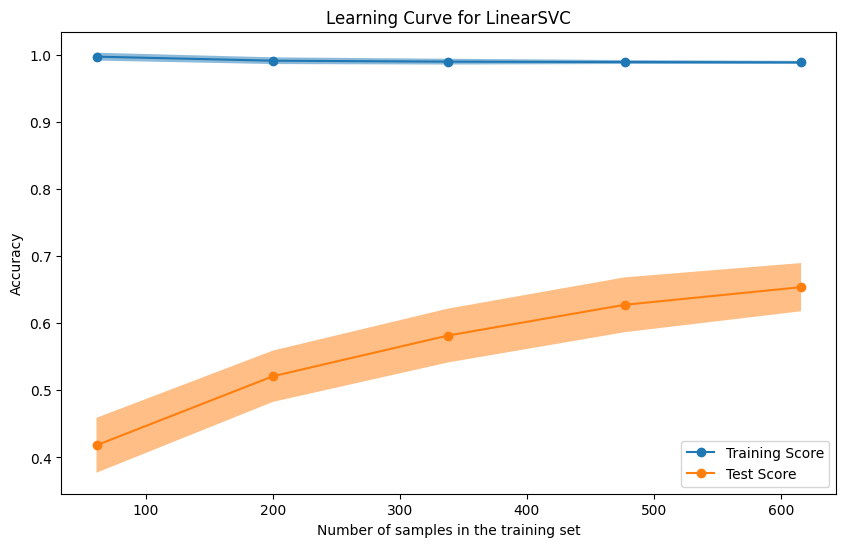

In [18]:
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))

common_params = {
    "X": X_val_tfidf,
    "y": y_val,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=20, test_size=0.2, random_state=42),
    "score_type": "both",
    "n_jobs": 1,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

LearningCurveDisplay.from_estimator(clf, **common_params, ax=ax)
handles, label = ax.get_legend_handles_labels()
ax.legend(handles[:2], ["Training Score", "Test Score"])
ax.set_title(f"Learning Curve for {clf.__class__.__name__}")

The training score remains high regardless of the size of the training set. On the other hand, the test score increases with the size of the training dataset. Indeed, it increases up to a point where it reaches a plateau. Observing such a plateau is an indication that it might not be useful to acquire new data to train the model since the generalization performance of the model will not increase anymore



In [19]:
model = clf.fit(X_train_tfidf, y_train)

top 5 keywords per class:
                0       1     2    3    4     5      6      7      8     9   \
0              jeg      er    og   og   og   med  eller    for   ikke    og   
1         arbeidet      av  ikke  kan  for    en     as  eller     no   for   
2  driftsansvarlig      re  dato   er  rer    rt   ikke    the    med   til   
3              nei  number   har  har   pa    pa     du    etg  eller  skal   
4           krever     kan   ved  nei  utf  skal    kan     og    den  type   

   ...       14      15       16        17   18    19    20      21    22   23  
0  ...       mm      as      med       til   er   nei    mm  number    av   av  
1  ...       no     abb      for     eller  nei   til    rt      se    er   er  
2  ...     ring      en    eller  anlegget  som  ring  with      de   for  til  
3  ...      som  utstyr      tak        er  kan    en   fra    ikke   vil  for  
4  ...  adresse    inst  armatur       den   ja    ma   som     nei  heis  som  

[5 rows x 24

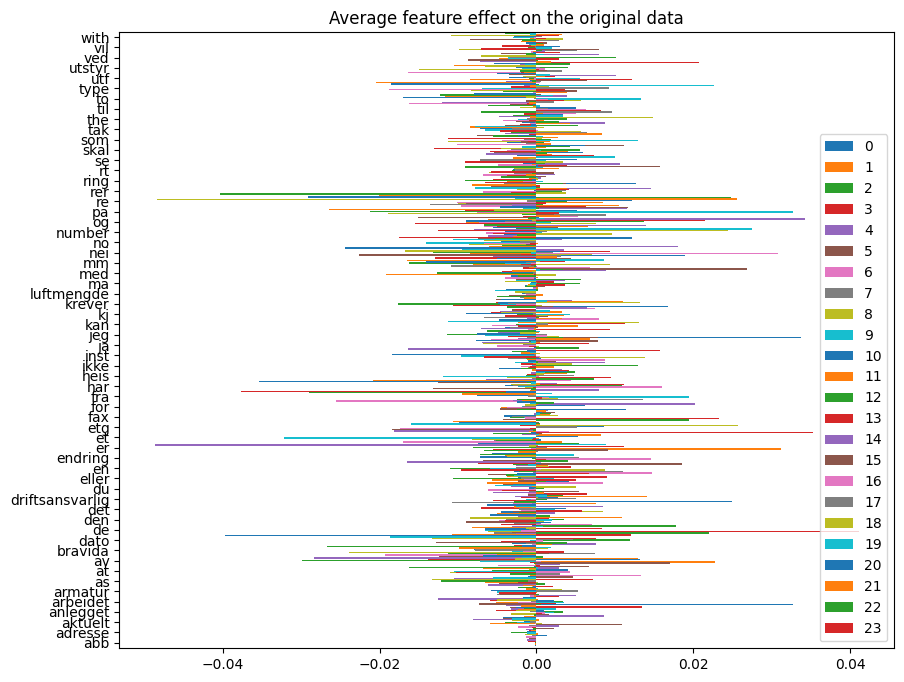

In [20]:
target_names = filtered_train_df['encoded_category'].sort_values().unique()
feature_names = tfidf_vectorizer.get_feature_names_out()

def plot_feature_effects():
    # learned coefficients weighted by frequency of appearance
    average_feature_effects = clf.coef_ * np.asarray(X_train_tfidf.mean(axis=0)).ravel()

    for i, label in enumerate(target_names):
        top5 = np.argsort(average_feature_effects[i])[-5:][::-1]
        if i == 0:
            top = pd.DataFrame(feature_names[top5], columns=[label])
            top_indices = top5
        else:
            top[label] = feature_names[top5]
            top_indices = np.concatenate((top_indices, top5), axis=None)
    top_indices = np.unique(top_indices)
    predictive_words = feature_names[top_indices]

    # plot feature effects
    bar_size = 0.25
    padding = 0.85
    y_locs = np.arange(len(top_indices)) * (4 * bar_size + padding)

    fig, ax = plt.subplots(figsize=(10, 8))
    for i, label in enumerate(target_names):
        ax.barh(
            y_locs + (i - 2) * bar_size,
            average_feature_effects[i, top_indices],
            height=bar_size,
            label=label,
        )
    ax.set(
        yticks=y_locs,
        yticklabels=predictive_words,
        ylim=[
            0 - 4 * bar_size,
            len(top_indices) * (4 * bar_size + padding) - 4 * bar_size,
        ],
    )
    ax.legend(loc="lower right")

    print("top 5 keywords per class:")
    print(top)

    return ax


_ = plot_feature_effects().set_title("Average feature effect on the original data")

In [21]:
y_train_pred = model.predict(X_train_tfidf)

print(
    f"Classification report for classifier {clf}:\n"
    f"{classification_report(y_train, y_train_pred)}\n"
)

Classification report for classifier LinearSVC(C=1, class_weight='balanced', dual=False, random_state=42):
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1092
           1       0.90      1.00      0.95        84
           2       0.96      0.95      0.96       165
           3       0.96      0.97      0.97       227
           4       0.97      0.97      0.97       486
           5       0.95      0.97      0.96       271
           6       0.99      0.98      0.99       206
           7       0.98      0.99      0.98       187
           8       0.96      0.96      0.96       191
           9       0.84      0.92      0.88       155
          10       0.98      1.00      0.99       148
          11       0.86      0.97      0.91       116
          12       0.96      0.92      0.94       619
          13       1.00      0.97      0.98       712
          14       0.90      0.99      0.95       115
          15       0.99     

## Evaluation

[Text(0, 0, '164'),
 Text(0, 0, '13'),
 Text(0, 0, '25'),
 Text(0, 0, '34'),
 Text(0, 0, '73'),
 Text(0, 0, '41'),
 Text(0, 0, '31'),
 Text(0, 0, '28'),
 Text(0, 0, '28'),
 Text(0, 0, '23'),
 Text(0, 0, '22'),
 Text(0, 0, '17'),
 Text(0, 0, '93'),
 Text(0, 0, '107'),
 Text(0, 0, '17'),
 Text(0, 0, '111'),
 Text(0, 0, '48'),
 Text(0, 0, '13'),
 Text(0, 0, '34'),
 Text(0, 0, '37'),
 Text(0, 0, '16'),
 Text(0, 0, '14'),
 Text(0, 0, '26'),
 Text(0, 0, '140')]

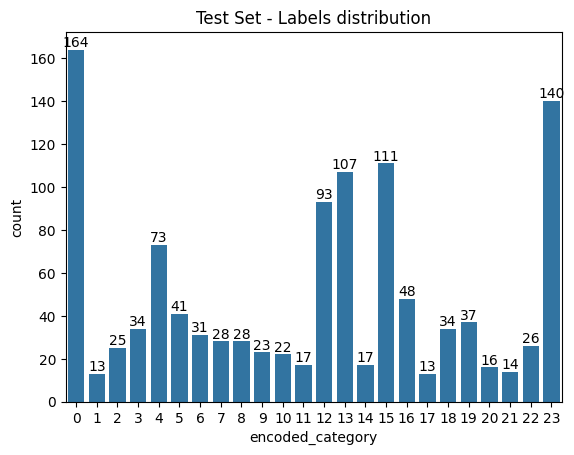

In [22]:
ax = sns.countplot(filtered_test_df, x="encoded_category")
ax.set_title("Test Set - Labels distribution")
ax.bar_label(ax.containers[0])

In [23]:
y_pred = model.predict(X_test_tfidf)


Classification report for classifier LinearSVC(C=1, class_weight='balanced', dual=False, random_state=42):
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       164
           1       0.83      0.77      0.80        13
           2       0.87      0.80      0.83        25
           3       0.55      0.50      0.52        34
           4       0.75      0.79      0.77        73
           5       0.66      0.93      0.77        41
           6       0.79      0.71      0.75        31
           7       0.93      0.96      0.95        28
           8       0.74      0.71      0.73        28
           9       0.55      0.70      0.62        23
          10       0.73      0.86      0.79        22
          11       0.52      0.76      0.62        17
          12       0.87      0.77      0.82        93
          13       0.97      0.98      0.98       107
          14       0.68      0.88      0.77        17
          15       0.90     

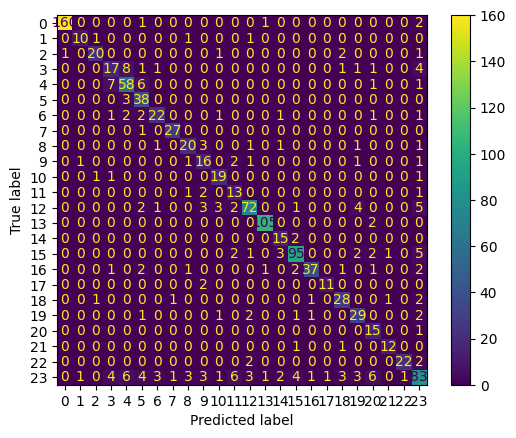

In [24]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

print(
    f"Classification report for classifier {clf}:\n"
    f"{classification_report(y_test, y_pred)}\n"
)
